In [1]:
import scipy
import pandas as pd
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import networkx as nx
from nibabel import freesurfer as fs

%load_ext rpy2.ipython

In [2]:
%%R

suppressPackageStartupMessages({
    library(cowplot)
    library(glue)
    library(ggseg)
    library(ggsegGlasser)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
})


In [3]:
data_path = "/Users/abry4213/data/OCDA" 

# Read in Glasser 180 right hemisphere
glasser180_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Glasser_2016/fsaverage/rh.HCP-MMP1.annot"
glasser180_right_vertices, glasser180_right_ctab, glasser180_right_names = fs.read_annot(glasser180_right_file)
glasser180_right_names = [name.decode() for name in glasser180_right_names]

# Create Glasser 180 right hemi lookup table
glasser180_right_LUT = pd.DataFrame({'index': np.arange(0, len(glasser180_right_names)), 'Glasser_RH_ROI': glasser180_right_names})

# Convert glasser array to dataframe
glasser180_right_df = pd.DataFrame({'index': glasser180_right_vertices, 'vertex_number': np.arange(0, len(glasser180_right_vertices))})
glasser180_right_df['Glasser_RH_ROI'] = glasser180_right_df['index'].map(glasser180_right_LUT.set_index('index')['Glasser_RH_ROI'])

# Drop index
glasser180_right_df = glasser180_right_df.drop(columns=['index'])

# Analysis 2: Sticking with 100 resolutions, sweeping across tolerances [0.01, 1]

In [4]:
# Generate a list of tol values from 0.01 to 1 in increments of 0.01 
tol_values = [str(round(i, 2)) for i in np.arange(0.01, 1, 0.01)]

# Use 1000 seeds
num_seeds = 100

# Use 100 iterations
num_iters = 100

all_module_counts_list = []
# all_cluster_assignments_list = []

for seed_number in range(1, num_seeds+1):
    for tol in tol_values:
        tol_str = np.where(len(str(tol).split(".")[1]) > 1, str(tol), str(tol) + "0")
        # Read in the file 
        file_name = f"{data_path}/OSLOM_results/OSLOM_seed_{seed_number}_iters_{num_iters}_tol_{tol_str}.txt"

        # Read in the file
        try:
            with open(file_name, 'r') as f:
                lines = f.readlines()

                # Look for lines beginning with #module 
                module_lines = [line for line in lines if line.startswith("#module")]

                # Get the number of modules
                num_modules = len(module_lines)

                # Look for non-module lines
                cluster_assignment_lines = [line for line in lines if not line.startswith("#")]
                num_clusters = len(cluster_assignment_lines)

                 # Convert the dictionary to a pandas dataframe, with one row per item in each value
                cluster_assignments = {i: cluster_assignment_lines[i].split() for i in range(num_modules)}
                cluster_assignments_df = (pd.DataFrame([(key, node) for key, nodes in cluster_assignments.items() for node in nodes], columns=['module', 'node']))
                num_overlapping_nodes = cluster_assignments_df.groupby('node').size().value_counts().values[1]

                overlapping_nodes = cluster_assignments_df.groupby('node').agg({'module': 'nunique'}).query("module > 1").index.values

                # Convert overlapping nodes to integers
                overlapping_nodes = [int(node) for node in overlapping_nodes]

                # Append the number of modules to the list
                file_res = pd.DataFrame({'p_threshold': tol,
                                        'num_iters': num_iters, 
                                        'seed_num': seed_number, 
                                        'num_modules': num_modules,
                                        'num_overlapping_nodes': num_overlapping_nodes}, index=[0])
                all_module_counts_list.append(file_res)

        except Exception as e:
            print(f"Error with file: {file_name}")
            print(e)

# Combine the results into a single dataframe
all_module_counts = pd.concat(all_module_counts_list)

Error with file: /Users/abry4213/data/OCDA/OSLOM_results/OSLOM_seed_24_iters_100_tol_0.24.txt
index 1 is out of bounds for axis 0 with size 1
Error with file: /Users/abry4213/data/OCDA/OSLOM_results/OSLOM_seed_75_iters_100_tol_0.18.txt
index 1 is out of bounds for axis 0 with size 1


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


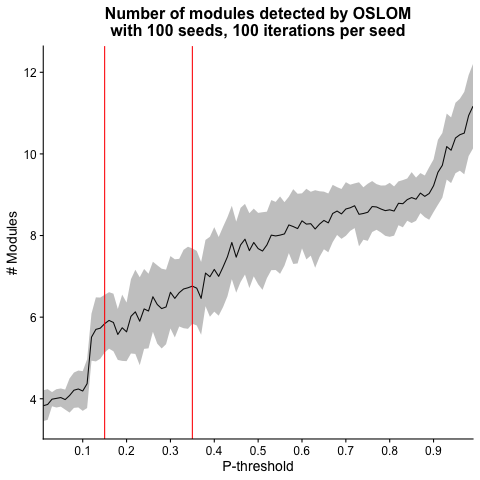

In [9]:
%%R -i all_module_counts

all_module_counts %>%
    mutate(p_threshold = as.numeric(p_threshold)) %>%
    group_by(p_threshold) %>%
    summarise(mean_num_modules = mean(num_modules), 
              sd_num_modules = sd(num_modules)) %>% 
    ggplot(data=., mapping=aes(x=p_threshold, y=mean_num_modules)) +
    geom_line() +
    geom_ribbon(aes(ymin=mean_num_modules-sd_num_modules, ymax=mean_num_modules+sd_num_modules), alpha=0.3) +
    scale_y_continuous(breaks = c(4, 6, 8, 10, 12)) +
    scale_x_continuous(expand=c(0,0), breaks=seq(0, 1, 0.1)) +
    ylab("# Communities") +
    xlab("P-threshold") +
    ggtitle("Number of modules detected by OSLOM\nwith 100 seeds, 100 iterations per seed") +
    geom_vline(xintercept = c(0.15, 0.35), color="red") +
    theme(plot.title = element_text(hjust=0.5))
# ggsave("../Plots/OSLOM_validation_num_modules_100_seeds_100_iters.svg", width=5, height=3.5, dpi=300)

### How many overlapping nodes are detected across each p-value threshold?

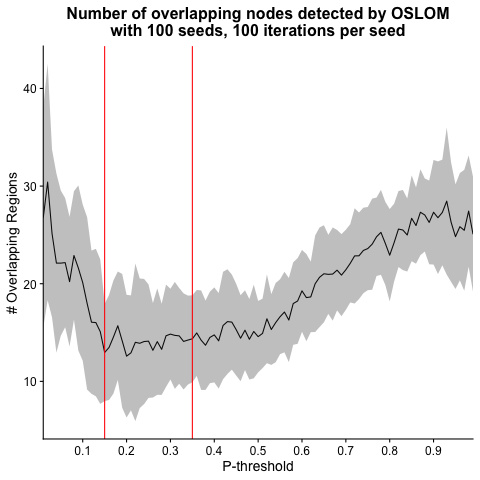

In [10]:
%%R -i all_module_counts

all_module_counts %>%
    mutate(p_threshold = as.numeric(p_threshold)) %>%
    group_by(p_threshold) %>%
    summarise(mean_num_modules = mean(num_overlapping_nodes), 
              sd_num_modules = sd(num_overlapping_nodes)) %>% 
    ggplot(data=., mapping=aes(x=p_threshold, y=mean_num_modules)) +
    geom_line() +
    geom_ribbon(aes(ymin=mean_num_modules-sd_num_modules, ymax=mean_num_modules+sd_num_modules), alpha=0.3) +
    scale_x_continuous(expand=c(0,0), breaks=seq(0, 1, 0.1)) +
    ylab("# Overlapping Nodes") +
    xlab("P-threshold") +
    ggtitle("Number of overlapping nodes detected by OSLOM\nwith 100 seeds, 100 iterations per seed") +
    geom_vline(xintercept = c(0.15, 0.35), color="red") +
    theme(plot.title = element_text(hjust=0.5))
# ggsave("../Plots/OSLOM_validation_num_overlapping_nodes_100_seeds_100_iters.svg", width=5, height=3.5, dpi=300)

### Seed--seed ENMI analysis across all evaluated tolerances

In [15]:
ENMI_results_by_tol_sweep_across_seeds = (pd.read_csv(f"{data_path}/OSLOM_results/ENMI_results_by_tol_sweep_across_seeds.csv", 
                                                     header=None, 
                                                     names=['target_p', 'target_seed', 'comparison_seed', 'ENMI'])
                                                     .query("target_seed != comparison_seed")
)


#### Can we look at the mean pairwise ENMI by seed at each threshold?

In [20]:
mean_pairwise_ENMI_by_seed = ENMI_results_by_tol_sweep_across_seeds.query("target_p >= 0.15 & target_p <= 0.35").groupby(["target_seed", "target_p"]).agg({"ENMI": "mean"}).reset_index()

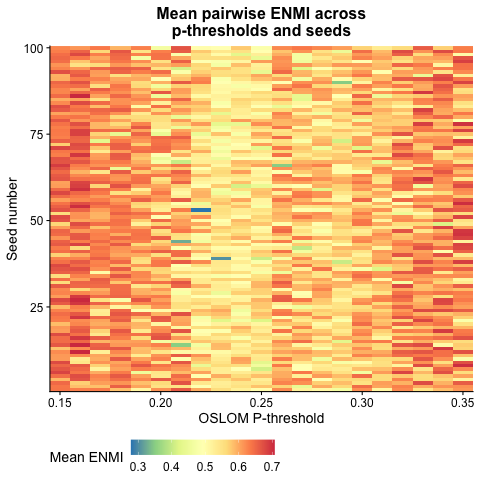

In [19]:
%%R -i mean_pairwise_ENMI_by_seed 

mean_pairwise_ENMI_by_seed %>% 
    ggplot(data=., mapping=aes(x=target_p, y=target_seed, fill=ENMI)) +
    geom_tile() +
    # geom_tile(data = seed39_p30_ENMI, fill = NA, color = "black") +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    ggtitle("Mean pairwise ENMI across\np-thresholds and seeds") +
    xlab("OSLOM P-threshold") +
    ylab("Seed number") +
    labs(fill="Mean ENMI") +
    guides(fill=guide_colorbar(barwidth = 10, units='cm')) +
    scale_fill_distiller(palette="Spectral") +
    theme(legend.position = "bottom") +
    theme(legend.position = "bottom",
          plot.title = element_text(hjust=0.5)) 
    
# ggsave("../Plots/Mean_pairwise_ENMI_heatmap.svg", width=4, height=4.5, units="in", dpi=300)

### What if we set the constraints (omitting the requirement of Aditi's nodes):  

* P = [0.15, 0.35]
* num_modules is 6 or 7
* min_module_size = 12 (smallest network previously, fronto-parietal, was 15)
* max_module_size = 60 (largest network previously, Visual + fronto-parietal, was 56)

In [116]:
# Generate a list of tol values from 0.01 to 1 in increments of 0.01 
tol_values = [str(round(i, 2)) for i in np.arange(0.15, 0.35, 0.01)]

# Use 1000 seeds
num_seeds = 100

# Use 100 iterations
num_iters = 100

constrained_module_results_list = []

for seed_number in range(1, num_seeds+1):
    for tol in tol_values:
        tol_str = np.where(len(str(tol).split(".")[1]) > 1, str(tol), str(tol) + "0")
        # Read in the file 
        file_name = f"{data_path}/OSLOM_results/OSLOM_seed_{seed_number}_iters_{num_iters}_tol_{tol_str}.txt"

        # Read in the file
        try:
            with open(file_name, 'r') as f:
                lines = f.readlines()

                # Look for lines beginning with #module 
                module_lines = [line for line in lines if line.startswith("#module")]

                # Get the number of modules, check for 6-7
                num_modules = len(module_lines)
                if not num_modules in [6, 7]:
                    continue

                # Look for non-module lines
                cluster_assignment_lines = [line for line in lines if not line.startswith("#")]
                num_clusters = len(cluster_assignment_lines)

                 # Convert the dictionary to a pandas dataframe, with one row per item in each value
                cluster_assignments = {i: cluster_assignment_lines[i].split() for i in range(num_modules)}
                
                # Find the length of each value in the dictionary
                lengths = [len(cluster_assignments[i]) for i in range(num_modules)]

                # Check if any values are less than 12 or greater than 60
                if any([length < 12 for length in lengths]) or any([length > 60 for length in lengths]):
                    continue

                # Find min and max module sizes
                min_module_size = min(lengths)
                max_module_size = max(lengths)

                # Go on to assigning clusters
                cluster_assignments_df = (pd.DataFrame([(key, node) for key, nodes in cluster_assignments.items() for node in nodes], columns=['module', 'node']))
                overlapping_nodes = cluster_assignments_df.groupby('node').agg({'module': 'nunique'}).query("module > 1").index.values

                # Convert overlapping nodes to integers
                overlapping_nodes = [int(node) for node in overlapping_nodes]
                num_overlapping_nodes = len(overlapping_nodes)


                # Check if the number is between 11 and 17
                if not 11 <= num_overlapping_nodes <= 17:
                    continue
                
                # Append the number of modules to the list
                file_res = pd.DataFrame({'p_threshold': tol,
                                        'num_iters': num_iters, 
                                        'seed_num': seed_number, 
                                        'num_modules': num_modules,
                                        'min_module_size': min_module_size,
                                        'max_module_size': max_module_size,
                                        'num_overlapping_nodes': num_overlapping_nodes}, index=[0])
                constrained_module_results_list.append(file_res)

        except Exception as e:
            print(f"Error with file: {file_name}")
            print(e)
            

# Combine the results into a single dataframe
constrained_module_results = (pd.concat(constrained_module_results_list)
                              .assign(p_threshold=lambda x: x['p_threshold'].astype(float))
                              .merge(mean_pairwise_ENMI_by_seed.rename(columns={"target_seed": "seed_num", "target_p": "p_threshold"}))
                              )

Final solution:

* Seed: 61
* P-threshold: 0.3
* Average ENMI to all other seeds at P=0.3: 0.640
* Number of modules: 7
* Number of overlapping regions in total: 15
* Smallest module: 14
* Largest module: 60

In [129]:
eval_p = '0.30'
eval_seed = 61

seed_61_subset = ENMI_results_by_tol_sweep_across_seeds.query(f"target_seed=={eval_seed} & target_p >= 0.15 & target_p <= 0.35").assign(target_p = lambda x: x['target_p'].astype(float))
not_seed_61_subset = ENMI_results_by_tol_sweep_across_seeds.query(f"target_seed!{eval_seed} & target_p >= 0.15 & target_p <= 0.35").assign(target_p = lambda x: x['target_p'].astype(float))

with open(f"{data_path}/OSLOM_results/OSLOM_seed_{eval_seed}_iters_{num_iters}_tol_{eval_p}.txt", 'r') as f:
    lines = f.readlines()

    # Look for lines beginning with #module 
    module_lines = [line for line in lines if line.startswith("#module")]

    # Get the number of modules
    num_modules = len(module_lines)

    # Look for non-module lines
    cluster_assignment_lines = [line for line in lines if not line.startswith("#")]

    # Create a dictionary to store the cluster assignments, with cluster number ranging from 1 to 
    # num_modules as the key and the values being a list of nodes from cluster_assignment_lines
    cluster_assignments_eval = {i: cluster_assignment_lines[i].split() for i in range(num_modules)}

    # Convert the dictionary to a pandas dataframe, with one row per item in each value
    cluster_assignments_eval_df = (pd.DataFrame([(key, node) for key, nodes in cluster_assignments_eval.items() for node in nodes], columns=['module', 'node'])
                            .assign(p_threshold=eval_p, num_iters=num_iters, seed_num=eval_seed)
                            .assign(node = lambda x: x['node'].astype(int)))

    overlapping_nodes_eval = cluster_assignments_eval_df.groupby('node').agg({'module': 'nunique'}).query("module > 1").index.values

    # Convert overlapping nodes to integers
    overlapping_nodes_eval = [int(node) for node in overlapping_nodes_eval]

In [ ]:
%%R -i seed_61_subset,not_seed_61_subset

seed_61_subset$target_p <- as.factor(seed_61_subset$target_p)
not_seed_61_subset$target_p <- as.factor(not_seed_61_subset$target_p)
combined_data <- plyr::rbind.fill(seed_61_subset, not_seed_61_subset)

ggplot(mapping=aes(x=target_p, y=ENMI)) +
    geom_violinhalf(data=plyr::rbind.fill(seed_61_subset, not_seed_61_subset), fill="gray85",
                    scale="width", color="black", position = position_dodge(width = 1), width=0.9)  +
    # geom_point(data=not_seed_61_subset, position = position_jitter(width = 0.1, height=0), color="gray60", alpha=0.2, size=0.4) +
    geom_point(data=seed_61_subset, position = position_jitter(width = 0.1, height=0), alpha=0.8, stroke=0, size=1,
               aes(color="Seed 61")) +
    stat_summary(data=plyr::rbind.fill(seed_61_subset, not_seed_61_subset), 
            color="black", fun="mean", geom="crossbar", width=0.5, linewidth=0.28, 
            show.legend=FALSE, position = position_dodge(width=3)) +
    stat_summary(data=seed_61_subset, 
            color="#4d1e66", fun="mean", geom="crossbar", width=0.5, linewidth=0.28, 
            show.legend=FALSE, position = position_dodge(width=3)) +
    scale_color_manual(values=c("#68298a")) +
    xlab("P-threshold evaluated") +
    ylab("ENMI netween seed pairs\nat given P-threshold") +
    ggtitle("Seed--seed pair ENMI at each P-threshold") +
    labs(color="Target seed") +
    theme(legend.position="bottom",
          plot.title = element_text(hjust=0.5),
          axis.text.x = element_text(angle=35, hjust=1))
# ggsave("../Plots/ENMI_results_by_tol_sweep_across_seeds_highlight_seed_61.svg", width=7, height=4, units="in", dpi=300)

In [25]:
# Compute mean and SD ENMI for seed 61
ENMI_results_by_tol_sweep_across_seeds.query("target_p==0.3 & target_seed != 61")['ENMI'].agg(['mean', 'std'])

mean    0.585616
std     0.103411
Name: ENMI, dtype: float64